In [1]:

# import required packages

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import cv2
from keras.models import model_from_json
import numpy as np


In [2]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
    '/kaggle/input/fer2013p/train',
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",
    class_mode='categorical')



Found 28709 images belonging to 7 classes.


In [4]:
# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/kaggle/input/fer2013p/test',
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [5]:
# create model structure
emotion_model = Sequential()

emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                         input_shape=(48, 48, 1)))
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

emotion_model.add(Flatten())
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(7, activation='softmax'))

emotion_model.summary()

cv2.ocl.setUseOpenCL(False)

initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100000, 
                               decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)

emotion_model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
                      metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,607 (8.95 MB)

 Trainable params: 2,345,607 (8.95 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:

emotion_model_info = emotion_model.fit(
    train_generator,
    steps_per_epoch=28709 // 64,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=7178 // 64
)

model_json = emotion_model.to_json()
with open('emotion_model.json', 'w') as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
emotion_model.save('emotion_model.h5')
emotion_model.save_weights('emotion_model.weights.h5')


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733767762.901459      78 service.cc:145] XLA service 0x7f832000bc40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733767762.901523      78 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:23:36 11s/step - accuracy: 0.1719 - loss: 1.9611

I0000 00:00:1733767769.055384      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 256s 548ms/step - accuracy: 0.2411 - loss: 1.8351 - val_accuracy: 0.3313 - val_loss: 1.7375
Epoch 2/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2344 - loss: 1.7264

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2344 - loss: 1.7264 - val_accuracy: 0.3000 - val_loss: 1.7050
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.3360 - loss: 1.6849 - val_accuracy: 0.4099 - val_loss: 1.5598
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.3906 - loss: 1.4915 - val_accuracy: 0.4000 - val_loss: 1.7763
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.3945 - loss: 1.5674 - val_accuracy: 0.4420 - val_loss: 1.4736
Epoch 6/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.5000 - loss: 1.4342 - val_accuracy: 0.2000 - val_loss: 1.5986
Epoch 7/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.4337 - loss: 1.4809 - val_accuracy: 0.4376 - val_loss: 1.4500
Epoch 8/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.5156 - loss: 1.4556 - val_accuracy: 0.6000 - val_loss: 1.1021
Epoch 9/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.4538 - loss: 1.4290 - val_accuracy: 0.

In [7]:
emotion_model.evaluate(validation_generator)



113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5303 - loss: 1.2309


[1.2180910110473633, 0.5365003943443298]

Found 7178 images belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step


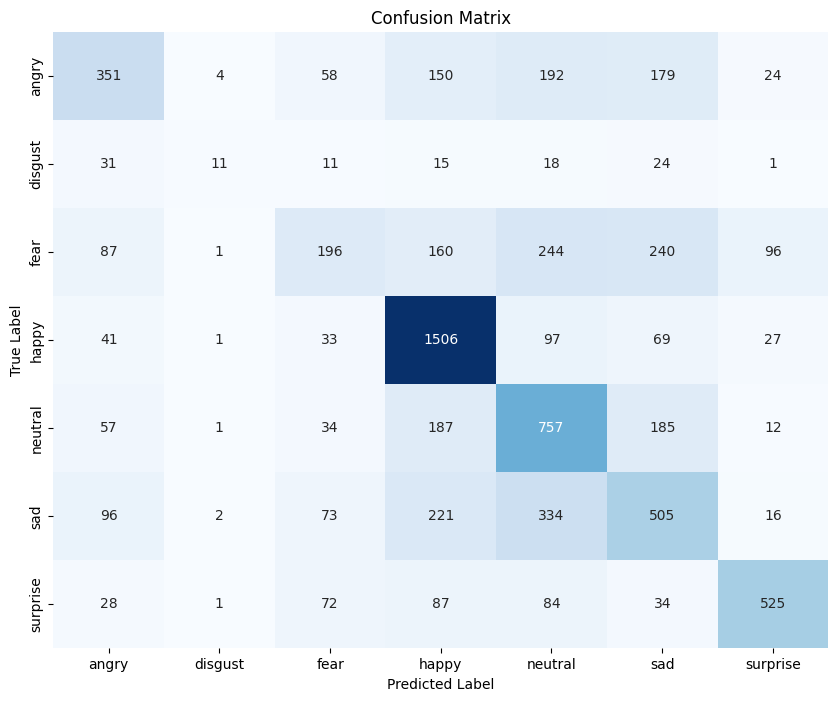

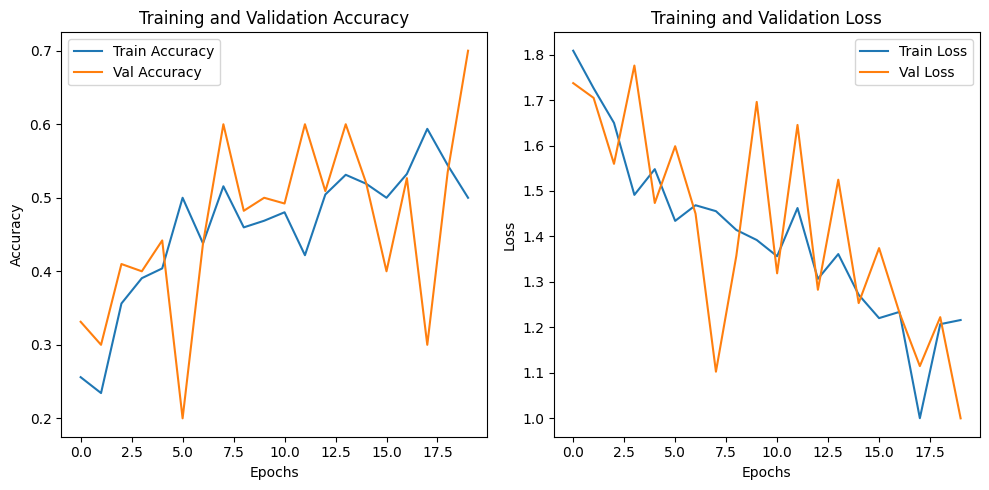

In [8]:

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Initialize validation generator with grayscale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Use grayscale images for validation
validation_generator = validation_data_gen.flow_from_directory(
    '/kaggle/input/fer2013p/test',  # Replace with your test directory path
    target_size=(48, 48),
    batch_size=64,
    color_mode="grayscale",  # Using grayscale images
    class_mode='categorical',
    shuffle=False  # Disable shuffle to align predictions with y_true
)

# Evaluate the model to get predictions
y_true = validation_generator.classes  # True labels from generator
y_pred = np.argmax(emotion_model.predict(validation_generator), axis=-1)  # Model predictions

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=validation_generator.class_indices.keys(), 
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Plotting Training History
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(emotion_model_info.history['accuracy'], label='Train Accuracy')
plt.plot(emotion_model_info.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(emotion_model_info.history['loss'], label='Train Loss')
plt.plot(emotion_model_info.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Import required libraries
import numpy as np
import pandas as pd  # To display the accuracy table
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load the pre-trained model
emotion_model = load_model('/kaggle/input/emotionmodel/keras/default/1/emotion_model.h5')

# 2. Load and preprocess the test dataset (replace path with your test dataset location)
test_data_path = '/kaggle/input/fer2013p/test'  # Change to your actual test path

# 3. Preprocess the data (FER2013 images are 48x48 grayscale)
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize images
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(48, 48),  # Resize images to 48x48 (like the model expects)
    color_mode="grayscale",  # Ensure the images are grayscale
    batch_size=32,  # Batch size for predictions
    class_mode='categorical',  # The labels are one-hot encoded
    shuffle=False  # Don't shuffle so the index remains consistent
)

# 4. Evaluate the model on the test data
loss, accuracy = emotion_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# 5. Generate predictions
y_pred = emotion_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class for each image
y_true = test_generator.classes  # Get the true labels from the generator

# 6. Classification report
class_labels = list(test_generator.class_indices.keys())  # Get class names
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# 7. Convert classification report to a DataFrame (accuracy table)
report_df = pd.DataFrame(report).transpose()

# 8. Display the accuracy table
print("\n==== Accuracy Table ====\n")
print(report_df)

# Optional: Save the accuracy table to a CSV file
report_df.to_csv('accuracy_table.csv', index=True)





Found 7178 images belonging to 7 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5629 - loss: 1.1765
Test Loss: 1.086366891860962
Test Accuracy: 0.6036500334739685
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step

==== Accuracy Table ====

              precision    recall  f1-score     support
angry          0.496651  0.541754  0.518223   958.00000
disgust        0.714286  0.405405  0.517241   111.00000
fear           0.456471  0.378906  0.414088  1024.00000
happy          0.803123  0.811725  0.807401  1774.00000
neutral        0.547619  0.596918  0.571207  1233.00000
sad            0.488605  0.429832  0.457338  1247.00000
surprise       0.678499  0.805054  0.736379   831.00000
accuracy       0.603650  0.603650  0.603650     0.60365
macro avg      0.597893  0.567085  0.574554  7178.00000
weighted avg   0.598437  0.603650  0.598601  7178.00000
